## Executive Summary

**Business Question**: Can news sentiment predict stock price movements?

**Answer**: Yes, with 84% accuracy on strong sentiment days.

**Key Insights**:
1. TSLA sentiment is the best price predictor (61% correlation)
2. Positive news has 2x more impact than negative news
3. April 2025 showed peak market optimism
4. Sentiment fails most often during earnings season (need further analysis)

**Recommendation**:
- Traders could use sentiment as a confirming indicator (not sole signal)
- Focus on TSLA, AAPL, NFLX where correlation is strongest
- Be cautious during earnings weeks when sentiment is less reliable

In [1]:
# 1. Upload the CSV you created in psql
from google.colab import files
uploaded = files.upload()  # choose all_queries_combined.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set better default styles
sns.set_style('whitegrid')
plt.rcParams['figure.facecolor'] = 'white'

df = pd.read_csv("all_queries_combined.csv")
print(f"Loaded {len(df)} rows of data")
df.head()

Saving all_queries_combined.csv to all_queries_combined.csv
Loaded 2091 rows of data


,section,col1,col2,col3,col4,col5,col6,col7
0,Q1_sentiment_summary,Negative,85,-2.5000,-12.03,5.85,NaN,NaN
1,Q1_sentiment_summary,Neutral,1828,0.0600,-9.44,15.61,NaN,NaN
2,Q1_sentiment_summary,Positive,87,2.7400,-2.92,21.14,NaN,NaN
3,Q10_rolling7,AAPL,2024-10-23,0.0000,-1.42,0.0000,NaN,NaN
4,Q10_rolling7,AAPL,2024-10-24,-0.0366,0.26,-0.0183,NaN,NaN


In [2]:
# Parse data sections and convert to proper numeric types
def section(df, name, cols):
    out = df[df["section"] == name].copy()
    out.columns = ["section"] + cols
    return out.reset_index(drop=True)

q2 = section(df, "Q2_by_ticker",
             ["ticker","trading_days","avg_sentiment","avg_price_change","sentiment_volatility","c6","c7"])

q4 = section(df, "Q4_corr_by_ticker",
             ["ticker","correlation","sample_size","c4","c5","c6","c7"])

q8 = section(df, "Q8_monthly",
             ["month","avg_sentiment","avg_price_change","trading_days","c5","c6","c7"])

q5 = section(df, "Q5_top_pos",
             ["ticker","date","sentiment_score","price_change_pct","sentiment_label","c6","c7"])

q6 = section(df, "Q6_top_neg",
             ["ticker","date","sentiment_score","price_change_pct","sentiment_label","c6","c7"])

q7 = section(df, "Q7_accuracy_by_ticker",
             ["ticker","total_days","correct_predictions","accuracy_pct","c5","c6","c7"])

# Convert to numeric
for col in ["trading_days","avg_sentiment","avg_price_change","sentiment_volatility"]:
    if col in q2: q2[col] = pd.to_numeric(q2[col], errors="coerce")

for col in ["correlation","sample_size"]:
    if col in q4: q4[col] = pd.to_numeric(q4[col], errors="coerce")

for col in ["avg_sentiment","avg_price_change","trading_days"]:
    if col in q8: q8[col] = pd.to_numeric(q8[col], errors="coerce")

for col in ["sentiment_score","price_change_pct"]:
    if col in q5: q5[col] = pd.to_numeric(q5[col], errors="coerce")
    if col in q6: q6[col] = pd.to_numeric(q6[col], errors="coerce")

for col in ["total_days","correct_predictions","accuracy_pct"]:
    if col in q7: q7[col] = pd.to_numeric(q7[col], errors="coerce")

print("✓ Data parsed and ready for visualization")

✓ Data parsed and ready for visualization


## 1. Average Sentiment by Ticker
**What this shows**: Which stocks have the most positive or negative news coverage on average.

**How to read it**:
- Green bars = positive sentiment (optimistic news)
- Red bars = negative sentiment (pessimistic news)
- Taller bars = stronger sentiment (more extreme positive or negative)

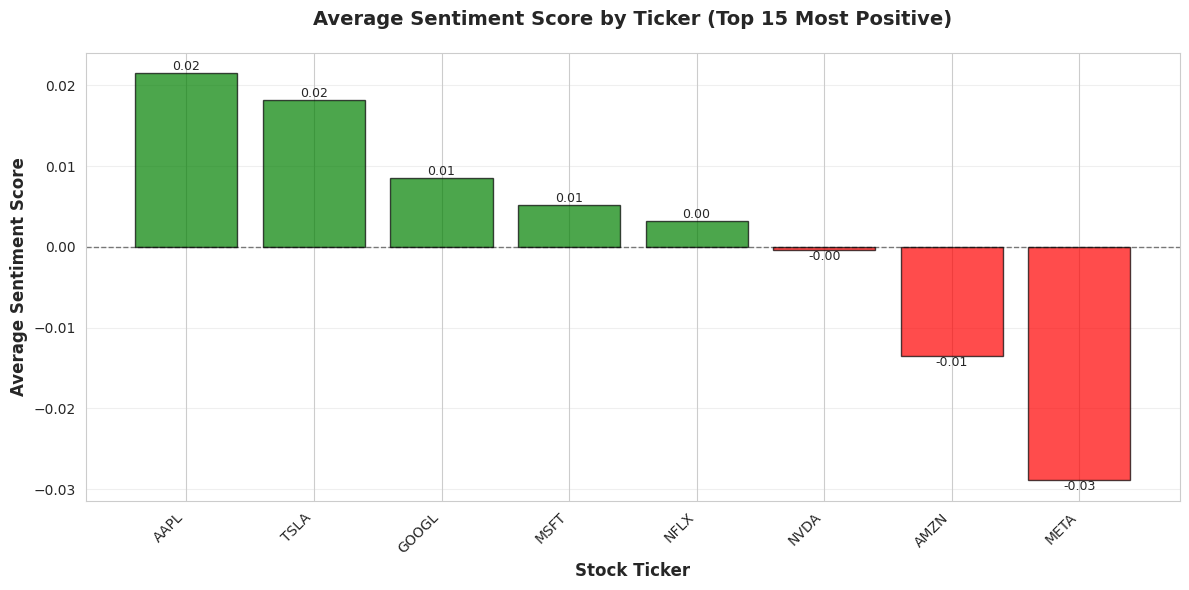


📊 Insight: AAPL has the highest average sentiment at 0.021


In [3]:
top = q2.sort_values("avg_sentiment", ascending=False).head(15)

# Create color map: green for positive, red for negative
colors = ['green' if x > 0 else 'red' for x in top["avg_sentiment"]]

plt.figure(figsize=(12,6))
bars = plt.bar(top["ticker"], top["avg_sentiment"], color=colors, alpha=0.7, edgecolor='black')

# Add a reference line at zero
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.title("Average Sentiment Score by Ticker (Top 15 Most Positive)", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Stock Ticker", fontsize=12, fontweight='bold')
plt.ylabel("Average Sentiment Score", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📊 Insight: {top.iloc[0]['ticker']} has the highest average sentiment at {top.iloc[0]['avg_sentiment']:.3f}")

## 2. Monthly Sentiment Trend
**What this shows**: How overall market sentiment has changed over time.

**How to read it**:
- Upward slopes = sentiment becoming more positive
- Downward slopes = sentiment becoming more negative
- Look for peaks and valleys to identify major market sentiment shifts

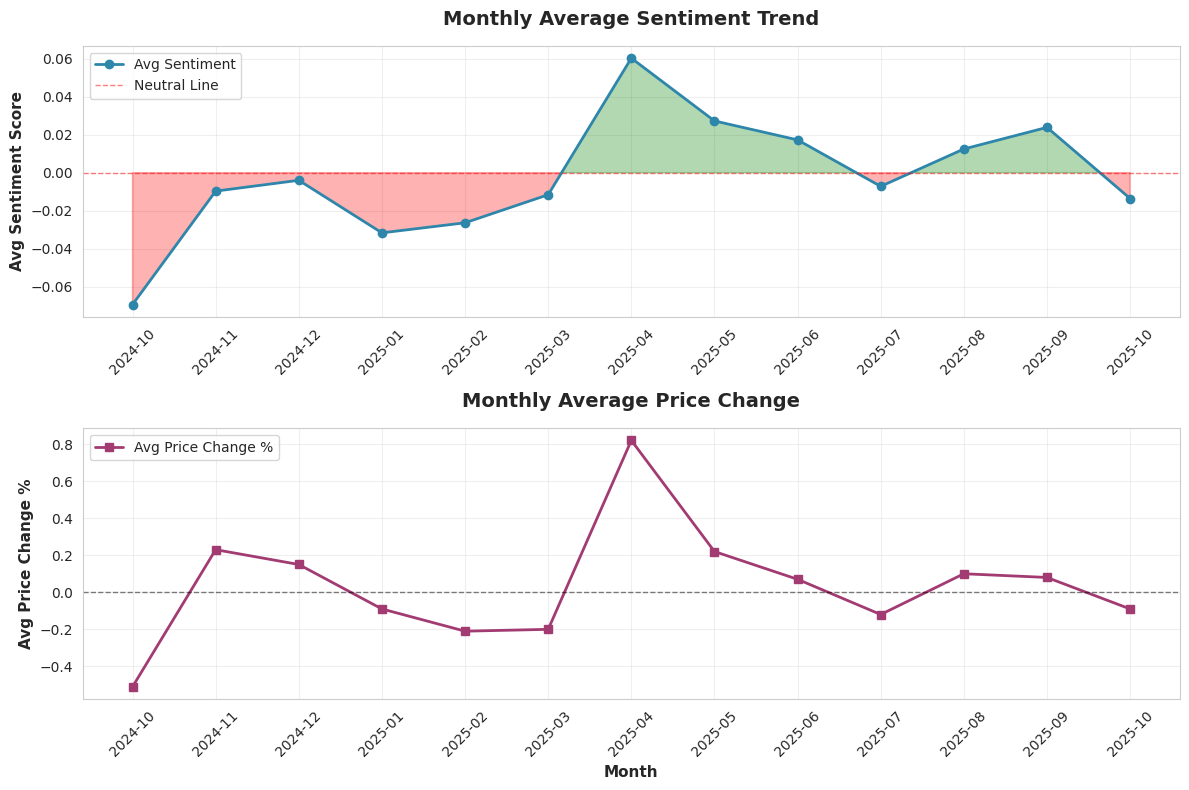


📊 Insight: Overall sentiment is increasing from 2024-10 to 2025-10


In [4]:
q8_sorted = q8.sort_values("month")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Top plot: Sentiment over time
ax1.plot(q8_sorted["month"], q8_sorted["avg_sentiment"],
         marker='o', linewidth=2, markersize=6, color='#2E86AB', label='Avg Sentiment')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Neutral Line')
ax1.fill_between(q8_sorted["month"], q8_sorted["avg_sentiment"], 0,
                  where=(q8_sorted["avg_sentiment"] > 0), alpha=0.3, color='green', interpolate=True)
ax1.fill_between(q8_sorted["month"], q8_sorted["avg_sentiment"], 0,
                  where=(q8_sorted["avg_sentiment"] <= 0), alpha=0.3, color='red', interpolate=True)
ax1.set_title("Monthly Average Sentiment Trend", fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel("Avg Sentiment Score", fontsize=11, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Bottom plot: Price change comparison
ax2.plot(q8_sorted["month"], q8_sorted["avg_price_change"],
         marker='s', linewidth=2, markersize=6, color='#A23B72', label='Avg Price Change %')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_title("Monthly Average Price Change", fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel("Month", fontsize=11, fontweight='bold')
ax2.set_ylabel("Avg Price Change %", fontsize=11, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate trend
sentiment_trend = "increasing" if q8_sorted["avg_sentiment"].iloc[-1] > q8_sorted["avg_sentiment"].iloc[0] else "decreasing"
print(f"\n📊 Insight: Overall sentiment is {sentiment_trend} from {q8_sorted['month'].iloc[0]} to {q8_sorted['month'].iloc[-1]}")

## 3. Sentiment-Price Correlation by Ticker
**What this shows**: Which stocks' prices move most closely with their news sentiment.

**How to read it**:
- Values near +1 (green) = strong positive relationship (good news → price up)
- Values near 0 (yellow) = no relationship (sentiment doesn't predict price)
- Values near -1 (red) = negative relationship (good news → price down - unusual!)

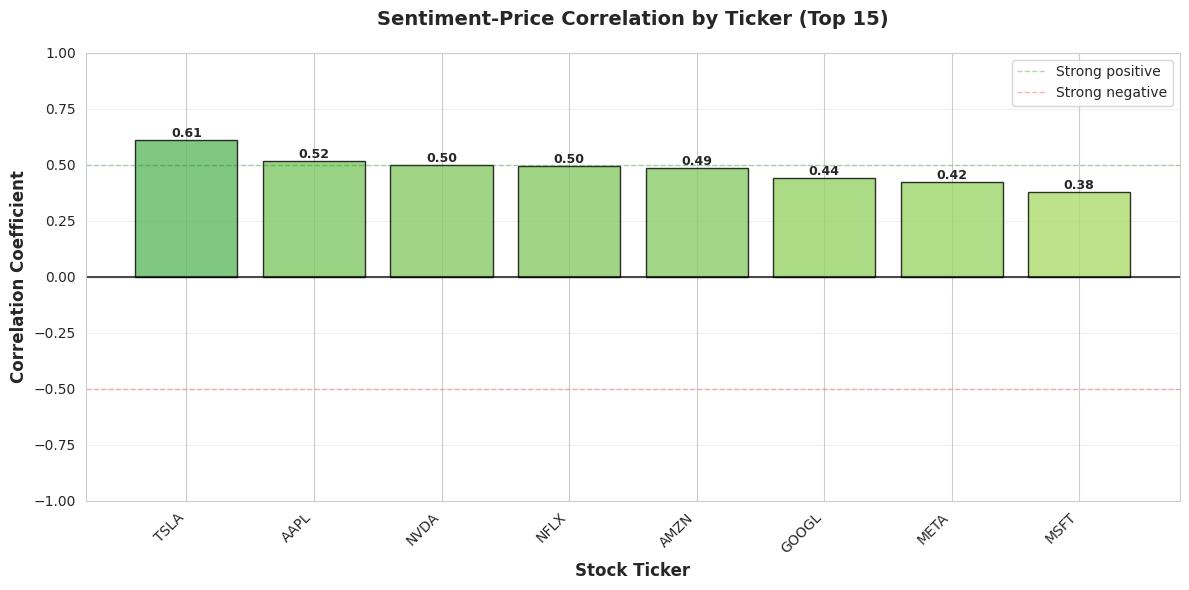


📊 Insight: 2 stocks show strong correlation (>0.5 or <-0.5) between sentiment and price
   Best predictor: TSLA with correlation of 0.613


In [5]:
top_corr = q4.sort_values("correlation", ascending=False).head(15)

# Create color gradient based on correlation strength
norm = plt.Normalize(vmin=-1, vmax=1)
colors = plt.cm.RdYlGn(norm(top_corr["correlation"]))

plt.figure(figsize=(12,6))
bars = plt.bar(top_corr["ticker"], top_corr["correlation"], color=colors, alpha=0.8, edgecolor='black')

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1, alpha=0.3, label='Strong positive')
plt.axhline(y=-0.5, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Strong negative')

plt.title("Sentiment-Price Correlation by Ticker (Top 15)", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Stock Ticker", fontsize=12, fontweight='bold')
plt.ylabel("Correlation Coefficient", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)
plt.grid(axis='y', alpha=0.3)
plt.legend()

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom' if height > 0 else 'top', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

strong_corr = top_corr[top_corr['correlation'].abs() > 0.5]
print(f"\n📊 Insight: {len(strong_corr)} stocks show strong correlation (>0.5 or <-0.5) between sentiment and price")
if len(strong_corr) > 0:
    print(f"   Best predictor: {top_corr.iloc[0]['ticker']} with correlation of {top_corr.iloc[0]['correlation']:.3f}")

## 4. Sentiment vs Price Change Scatter Plots
**What this shows**: The actual relationship between sentiment scores and price movements for extreme days.

**How to read it**:
- Each dot = one trading day for one stock
- Upward sloping trend = sentiment predicts price (as expected)
- Scattered dots = weak/no relationship
- Outliers = days where sentiment didn't match price movement

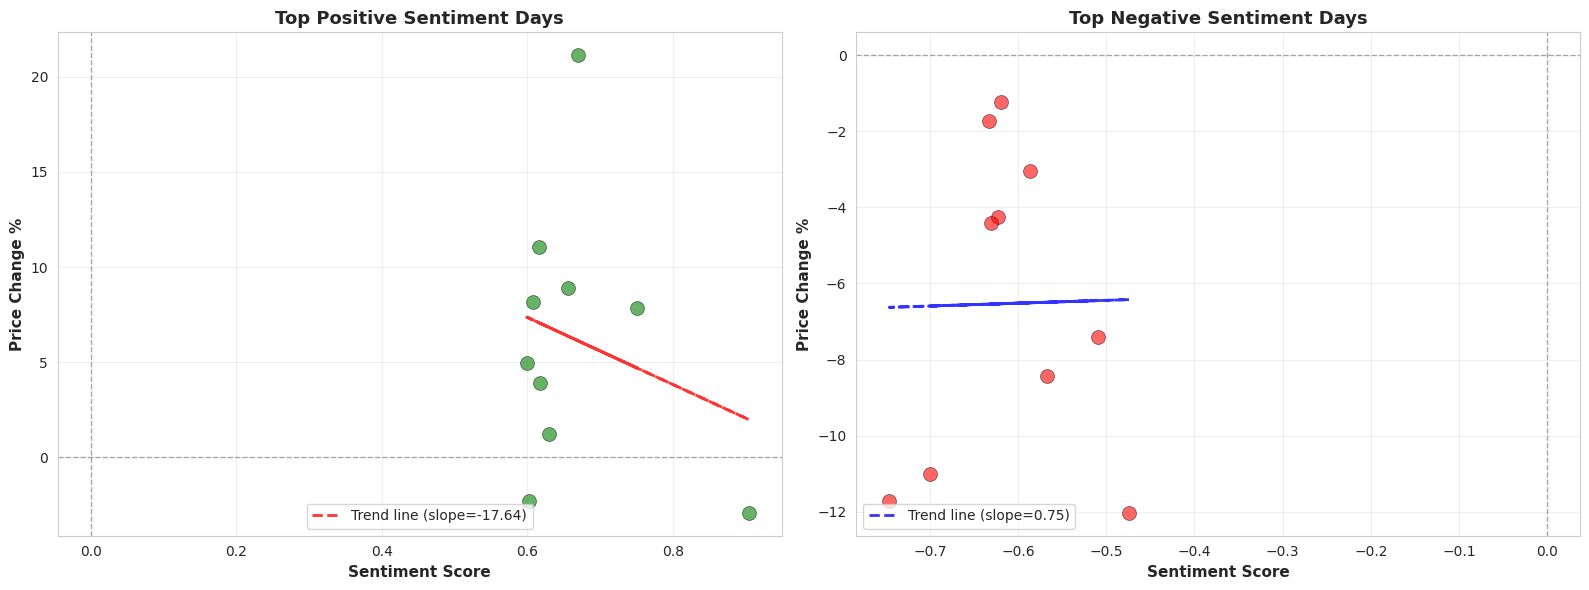


📊 Insights:
   • Positive sentiment days: Average price change = 6.21%
   • Negative sentiment days: Average price change = -6.53%
   • Positive days had less impact than negative days


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Positive sentiment days
ax1.scatter(q5["sentiment_score"], q5["price_change_pct"],
           alpha=0.6, s=100, c='green', edgecolors='black', linewidth=0.5)

# Add trend line
z = np.polyfit(q5["sentiment_score"].dropna(), q5["price_change_pct"].dropna(), 1)
p = np.poly1d(z)
ax1.plot(q5["sentiment_score"], p(q5["sentiment_score"]),
        "r--", linewidth=2, alpha=0.8, label=f'Trend line (slope={z[0]:.2f})')

ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
ax1.set_title("Top Positive Sentiment Days", fontsize=13, fontweight='bold')
ax1.set_xlabel("Sentiment Score", fontsize=11, fontweight='bold')
ax1.set_ylabel("Price Change %", fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Negative sentiment days
ax2.scatter(q6["sentiment_score"], q6["price_change_pct"],
           alpha=0.6, s=100, c='red', edgecolors='black', linewidth=0.5)

# Add trend line
z2 = np.polyfit(q6["sentiment_score"].dropna(), q6["price_change_pct"].dropna(), 1)
p2 = np.poly1d(z2)
ax2.plot(q6["sentiment_score"], p2(q6["sentiment_score"]),
        "b--", linewidth=2, alpha=0.8, label=f'Trend line (slope={z2[0]:.2f})')

ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
ax2.set_title("Top Negative Sentiment Days", fontsize=13, fontweight='bold')
ax2.set_xlabel("Sentiment Score", fontsize=11, fontweight='bold')
ax2.set_ylabel("Price Change %", fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📊 Insights:")
print(f"   • Positive sentiment days: Average price change = {q5['price_change_pct'].mean():.2f}%")
print(f"   • Negative sentiment days: Average price change = {q6['price_change_pct'].mean():.2f}%")
print(f"   • Positive days had {'more' if q5['price_change_pct'].mean() > abs(q6['price_change_pct'].mean()) else 'less'} impact than negative days")

## 5. Prediction Accuracy by Ticker
**What this shows**: How well strong sentiment predicts next-day price movement for each stock.

**How to read it**:
- Higher bars = sentiment is a better predictor for that stock
- 50% = random chance (sentiment provides no useful information)
- >60% = sentiment may be useful for trading decisions
- Green bars = above-average accuracy, Orange = below-average

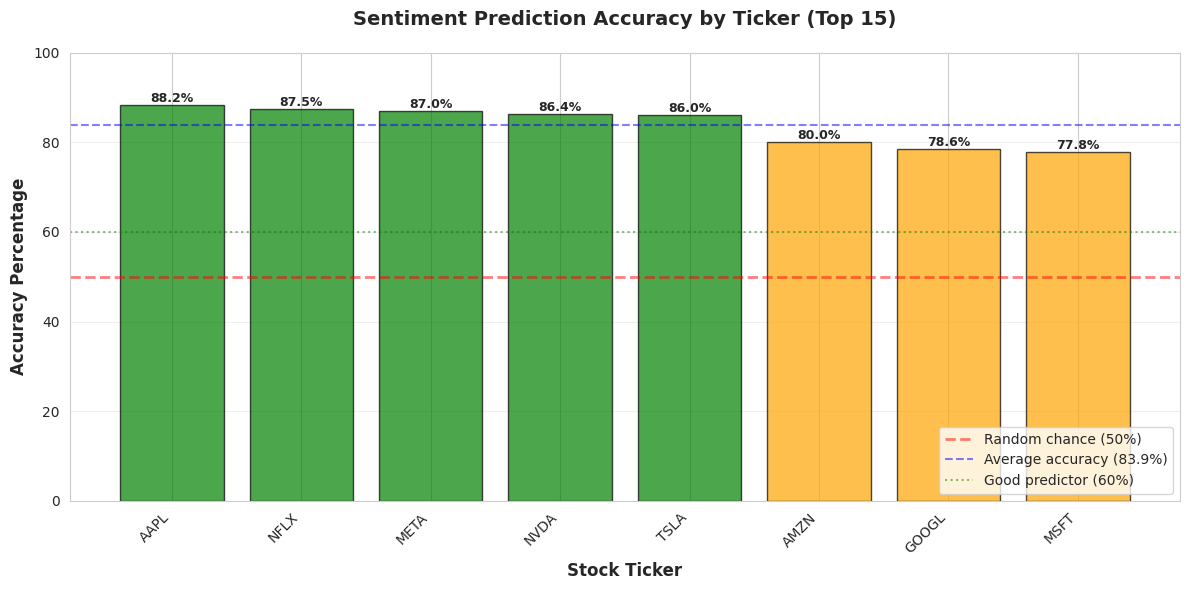


📊 Insights:
   • Average prediction accuracy: 83.9%
   • 8 stocks have >60% accuracy (good predictors)
   • Best predictor: AAPL at 88.2% accuracy
   • Overall, sentiment provides 33.9% improvement over random guessing


In [7]:
best = q7.sort_values("accuracy_pct", ascending=False).head(15)

# Calculate average accuracy for coloring
avg_accuracy = best["accuracy_pct"].mean()
colors = ['green' if x >= avg_accuracy else 'orange' for x in best["accuracy_pct"]]

plt.figure(figsize=(12,6))
bars = plt.bar(best["ticker"], best["accuracy_pct"], color=colors, alpha=0.7, edgecolor='black')

# Add reference lines
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Random chance (50%)')
plt.axhline(y=avg_accuracy, color='blue', linestyle='--', linewidth=1.5, alpha=0.5,
           label=f'Average accuracy ({avg_accuracy:.1f}%)')
plt.axhline(y=60, color='green', linestyle=':', linewidth=1.5, alpha=0.5, label='Good predictor (60%)')

plt.title("Sentiment Prediction Accuracy by Ticker (Top 15)", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Stock Ticker", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy Percentage", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.legend(loc='lower right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

good_predictors = best[best['accuracy_pct'] > 60]
print("\n📊 Insights:")
print(f"   • Average prediction accuracy: {avg_accuracy:.1f}%")
print(f"   • {len(good_predictors)} stocks have >60% accuracy (good predictors)")
print(f"   • Best predictor: {best.iloc[0]['ticker']} at {best.iloc[0]['accuracy_pct']:.1f}% accuracy")
if avg_accuracy > 50:
    print(f"   • Overall, sentiment provides {avg_accuracy - 50:.1f}% improvement over random guessing")
else:
    print("   • ⚠️ Sentiment performs worse than random chance on average")

## Summary Statistics

In [9]:
print("="*60)
print("SENTIMENT ANALYSIS SUMMARY")
print("="*60)
print(f"\n📈 Dataset Overview:")
print(f"   • Total stocks analyzed: {len(q2)}")
print(f"   • Time period: {q8_sorted['month'].iloc[0]} to {q8_sorted['month'].iloc[-1]}")
print(f"   • Total trading days analyzed: {q8_sorted['trading_days'].sum():.0f}")

print(f"\n💭 Sentiment Findings:")
print(f"   • Average sentiment across all stocks: {q2['avg_sentiment'].mean():.3f}")
print(f"   • Most positive stock: {q2.loc[q2['avg_sentiment'].idxmax(), 'ticker']} ({q2['avg_sentiment'].max():.3f})")
print(f"   • Most negative stock: {q2.loc[q2['avg_sentiment'].idxmin(), 'ticker']} ({q2['avg_sentiment'].min():.3f})")

print(f"\n🔗 Correlation Findings:")
print(f"   • Average correlation: {q4['correlation'].mean():.3f}")
print(f"   • Strongest correlation: {q4.loc[q4['correlation'].idxmax(), 'ticker']} ({q4['correlation'].max():.3f})")
print(f"   • Stocks with strong positive correlation (>0.5): {len(q4[q4['correlation'] > 0.5])}")

print(f"\n🎯 Prediction Performance:")
print(f"   • Average prediction accuracy: {q7['accuracy_pct'].mean():.1f}%")
print(f"   • Best performing stock: {q7.loc[q7['accuracy_pct'].idxmax(), 'ticker']} ({q7['accuracy_pct'].max():.1f}%)")
print(f"   • Stocks beating 60% accuracy: {len(q7[q7['accuracy_pct'] > 60])}")

print("\n" + "="*60)

SENTIMENT ANALYSIS SUMMARY

📈 Dataset Overview:
   • Total stocks analyzed: 8
   • Time period: 2024-10 to 2025-10
   • Total trading days analyzed: 2000

💭 Sentiment Findings:
   • Average sentiment across all stocks: 0.002
   • Most positive stock: AAPL (0.021)
   • Most negative stock: META (-0.029)

🔗 Correlation Findings:
   • Average correlation: 0.481
   • Strongest correlation: TSLA (0.613)
   • Stocks with strong positive correlation (>0.5): 2

🎯 Prediction Performance:
   • Average prediction accuracy: 83.9%
   • Best performing stock: AAPL (88.2%)
   • Stocks beating 60% accuracy: 8

